In [1]:
class GPUMonitor:
    """GPU使用率とメモリ使用量をモニタリング"""
    
    def __init__(self, interval=0.1):
        self.interval = interval
        self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        self.monitoring = False
        self.timestamps = deque(maxlen=10000)
        self.gpu_utils = deque(maxlen=10000)
        self.mem_utils = deque(maxlen=10000)
        self.mem_used = deque(maxlen=10000)
        self.thread = None
    
    def _monitor_loop(self):
        """モニタリングループ"""
        start_time = time.time()
        while self.monitoring:
            current_time = time.time() - start_time
            
            # GPU使用率
            util = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle)
            self.gpu_utils.append(util.gpu)
            
            # メモリ使用量
            mem_info = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
            self.mem_utils.append(100 * mem_info.used / mem_info.total)
            self.mem_used.append(mem_info.used / (1024**3))  # GB
            
            self.timestamps.append(current_time)
            time.sleep(self.interval)
    
    def start(self):
        """モニタリング開始"""
        self.monitoring = True
        self.thread = threading.Thread(target=self._monitor_loop)
        self.thread.start()
    
    def stop(self):
        """モニタリング停止"""
        self.monitoring = False
        if self.thread:
            self.thread.join()
    
    def get_data(self):
        """データ取得"""
        return {
            'timestamps': list(self.timestamps),
            'gpu_utils': list(self.gpu_utils),
            'mem_utils': list(self.mem_utils),
            'mem_used_gb': list(self.mem_used)
        }
    
    def plot(self, title="GPU Monitoring Results"):
        """結果のプロット"""
        data = self.get_data()
        if not data['timestamps']:
            print("No monitoring data available")
            return
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # GPU使用率
        ax1.plot(data['timestamps'], data['gpu_utils'], 'b-', linewidth=1.5)
        ax1.set_ylabel('GPU Utilization (%)')
        ax1.set_ylim(0, 105)
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f"{title} - GPU Utilization")
        
        # メモリ使用量
        ax2.plot(data['timestamps'], data['mem_used_gb'], 'r-', linewidth=1.5, label='Used')
        ax2.axhline(y=24, color='k', linestyle='--', alpha=0.5, label='Total (24GB)')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('GPU Memory (GB)')
        ax2.set_ylim(0, 26)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_title("GPU Memory Usage")
        
        plt.tight_layout()
        plt.show()
        
        # 統計情報
        print(f"\nGPU Utilization Statistics:")
        print(f"  Average: {np.mean(data['gpu_utils']):.1f}%")
        print(f"  Maximum: {np.max(data['gpu_utils']):.1f}%")
        print(f"  Minimum: {np.min(data['gpu_utils']):.1f}%")
        
        print(f"\nGPU Memory Statistics:")
        print(f"  Average: {np.mean(data['mem_used_gb']):.2f} GB")
        print(f"  Maximum: {np.max(data['mem_used_gb']):.2f} GB")
        print(f"  Minimum: {np.min(data['mem_used_gb']):.2f} GB")

# Helper functions
def print_rmm_statistics():
    """RMM統計情報を表示"""
    stats = rmm.statistics.get_statistics()
    print("\nRMM Memory Statistics:")
    print(f"  Current allocated: {stats.current_bytes / (1024**3):.2f} GB")
    print(f"  Peak allocated: {stats.peak_bytes / (1024**3):.2f} GB")
    print(f"  Total allocations: {stats.n_allocations}")
    print(f"  Total deallocations: {stats.n_deallocations}")

def print_cupy_memory_info():
    """CuPyメモリプール情報を表示"""
    mempool = cp.get_default_memory_pool()
    print("\nCuPy Memory Pool:")
    print(f"  Used: {mempool.used_bytes() / (1024**3):.2f} GB")
    print(f"  Total: {mempool.total_bytes() / (1024**3):.2f} GB")

# モニターのインスタンス化
monitor = GPUMonitor(interval=0.05)
print("GPU Monitor initialized")

NameError: name 'pynvml' is not defined

## 1.2 GPU使用率モニタリングクラス

In [2]:
# GPU monitoring tools
try:
    import pynvml
except ImportError:
    !pip install nvidia-ml-py3
    import pynvml

import cupy as cp
import rmm
from rmm.statistics import ProfilerRecords, statistics
import threading
from collections import deque
import gc
import psutil

# Initialize NVML for GPU monitoring
pynvml.nvmlInit()
gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

# Get GPU info
gpu_name = pynvml.nvmlDeviceGetName(gpu_handle).decode('utf-8')
gpu_mem_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
print(f"GPU: {gpu_name}")
print(f"GPU Memory: {gpu_mem_info.total / (1024**3):.1f} GB")

# RMM statistics を有効化
rmm.statistics.enable_statistics()

# RMM を再初期化（統計機能付き）
rmm.reinitialize(
    managed_memory=False,  # まずは通常のGPUメモリで試す
    pool_allocator=True,
    initial_pool_size=2<<30,    # 2GB
    maximum_pool_size=22<<30,   # 22GB (24GBの GPU用)
    logging=True
)

print("\nRMM memory profiling enabled")

AttributeError: 'str' object has no attribute 'decode'

# CANデータGPU処理ベンチマーク

CANバイナリデータのGPU処理とCPU処理の比較、およびParquet出力の検証を行います。

## 1. 環境設定とインポート

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import sys

# Add parent directory to path for imports
sys.path.append('..')

# Import decoders
from gpu_can_decoder import GPUCANDecoder
from cpu_can_decoder import CPUCANDecoder

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [4]:
def generate_synthetic_can_data(n_messages):
    """合成CANデータの生成（OpenPilot DBCファイルに準拠）"""
    # リアルなCANデータ分布を模倣
    address_distribution = {
        170: 0.037,  # 4輪速度
        37: 0.037,   # ステアリング
        36: 0.037,
        740: 0.044,
        608: 0.022,
        180: 0.018,
    }
    
    # アドレスを生成
    addresses = []
    for addr, prob in address_distribution.items():
        count = int(n_messages * prob)
        addresses.extend([addr] * count)
    
    # 残りはランダムなアドレス
    remaining = n_messages - len(addresses)
    other_addresses = np.random.choice([452, 466, 467, 705, 321, 562], remaining)
    addresses.extend(other_addresses)
    
    # シャッフル
    np.random.shuffle(addresses)
    addresses = np.array(addresses[:n_messages], dtype=np.int64)
    
    # タイムスタンプ（実データと同じ範囲）
    timestamps = np.linspace(46408.0, 46468.0, n_messages)
    
    # データバイト
    data_bytes = np.zeros((n_messages, 8), dtype=np.uint8)
    
    for i in range(n_messages):
        if addresses[i] == 170:  # 4輪速度
            # OpenPilot DBC: (0.01,-67.67) "kph" for Toyota RAV4
            for j in range(4):
                speed_kmh = np.random.uniform(55, 65)  # 55-65 km/h
                raw_value = int((speed_kmh + 67.67) / 0.01)
                data_bytes[i, j*2] = (raw_value >> 8) & 0xFF
                data_bytes[i, j*2 + 1] = raw_value & 0xFF
        elif addresses[i] == 37:  # ステアリング
            # 固定値パターン（実データと同じ）
            data_bytes[i] = [0x00, 0x00, 0x10, 0x00, 0xC0, 0x00, 0x00, 0xFD]
        else:
            # その他はランダム
            data_bytes[i] = np.random.randint(0, 256, 8, dtype=np.uint8)
    
    return timestamps, addresses, data_bytes

=== 生CANデータの列指向配列レイアウト ===

生CANデータは3つの列指向配列で構成されています：

1. タイムスタンプ配列 (timestamps):
   - 型: float64
   - 形状: (5,)
   - 例: [46408. 46423. 46438. 46453. 46468.]

2. アドレス配列 (addresses):
   - 型: int64
   - 形状: (5,)
   - 例: [466 466 705 467 452]

3. データバイト配列 (data_bytes):
   - 型: uint8
   - 形状: (5, 8)
   - 例:
     メッセージ0: [ 63 215 241  45  77 141  20 234]
     メッセージ1: [183  96 133  80 169 192  46  44]
     メッセージ2: [224  37  44 249  21 141 138 131]
     メッセージ3: [109 146  35 135 232  46 158 255]
     メッセージ4: [  2  91  79  80 224 180 158 149]

=== データレイアウトの特徴 ===
- 列指向: 各属性（timestamp, address, data）が個別の配列として格納
- 効率的: GPUでの並列処理に適した連続メモリレイアウト
- Apache Arrow互換: 列指向フォーマットへの変換が容易


/tmp/ipykernel_4044011/179498621.py:78: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4044011/179498621.py:78: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4044011/179498621.py:78: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4044011/179498621.py:78: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4044011/179498621.py:78: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4044011/179498621.py:78: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4044011/179498621.py:78: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-630

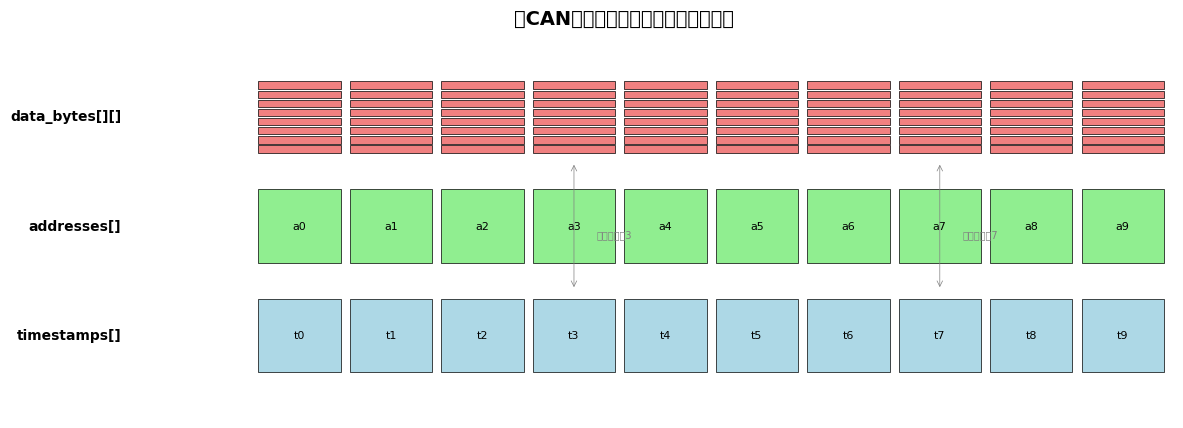


=== メモリ使用量の例 ===
    10,000 メッセージ:      0.2 MB
            - timestamps:    0.1 MB
            - addresses:     0.1 MB
            - data_bytes:    0.1 MB
   100,000 メッセージ:      2.3 MB
            - timestamps:    0.8 MB
            - addresses:     0.8 MB
            - data_bytes:    0.8 MB
 1,000,000 メッセージ:     22.9 MB
            - timestamps:    7.6 MB
            - addresses:     7.6 MB
            - data_bytes:    7.6 MB
10,000,000 メッセージ:    228.9 MB
            - timestamps:   76.3 MB
            - addresses:    76.3 MB
            - data_bytes:   76.3 MB


In [5]:
# 生CANデータの構造を確認
print("=== 生CANデータの列指向配列レイアウト ===\n")

# サンプルデータを生成して構造を表示
n_sample = 5
sample_timestamps, sample_addresses, sample_data_bytes = generate_synthetic_can_data(n_sample)

print("生CANデータは3つの列指向配列で構成されています：\n")

print("1. タイムスタンプ配列 (timestamps):")
print(f"   - 型: {sample_timestamps.dtype}")
print(f"   - 形状: {sample_timestamps.shape}")
print(f"   - 例: {sample_timestamps}")

print("\n2. アドレス配列 (addresses):")
print(f"   - 型: {sample_addresses.dtype}")
print(f"   - 形状: {sample_addresses.shape}")
print(f"   - 例: {sample_addresses}")

print("\n3. データバイト配列 (data_bytes):")
print(f"   - 型: {sample_data_bytes.dtype}")
print(f"   - 形状: {sample_data_bytes.shape}")
print(f"   - 例:")
for i in range(n_sample):
    print(f"     メッセージ{i}: {sample_data_bytes[i]}")

print("\n=== データレイアウトの特徴 ===")
print("- 列指向: 各属性（timestamp, address, data）が個別の配列として格納")
print("- 効率的: GPUでの並列処理に適した連続メモリレイアウト")
print("- Apache Arrow互換: 列指向フォーマットへの変換が容易")

# メモリレイアウトの可視化
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 各配列のメモリ表現
n_messages = 10
bar_height = 0.8

# タイムスタンプ配列
for i in range(n_messages):
    rect = mpatches.Rectangle((i, 0), 0.9, bar_height, 
                            facecolor='lightblue', edgecolor='black', linewidth=0.5)
    ax.add_patch(rect)
    ax.text(i + 0.45, 0.4, f't{i}', ha='center', va='center', fontsize=8)

# アドレス配列
for i in range(n_messages):
    rect = mpatches.Rectangle((i, 1.2), 0.9, bar_height, 
                            facecolor='lightgreen', edgecolor='black', linewidth=0.5)
    ax.add_patch(rect)
    ax.text(i + 0.45, 1.6, f'a{i}', ha='center', va='center', fontsize=8)

# データバイト配列（2次元）
for i in range(n_messages):
    for j in range(8):
        rect = mpatches.Rectangle((i, 2.4 + j * 0.1), 0.9, 0.08, 
                                facecolor='lightcoral', edgecolor='black', linewidth=0.5)
        ax.add_patch(rect)

ax.text(-1.5, 0.4, 'timestamps[]', ha='right', va='center', fontweight='bold')
ax.text(-1.5, 1.6, 'addresses[]', ha='right', va='center', fontweight='bold')
ax.text(-1.5, 2.8, 'data_bytes[][]', ha='right', va='center', fontweight='bold')

ax.set_xlim(-2, n_messages)
ax.set_ylim(-0.5, 3.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('生CANデータの列指向配列レイアウト', fontsize=14, fontweight='bold', pad=20)

# 矢印で各メッセージの関係を示す
for i in [3, 7]:  # 例として2つのメッセージ
    ax.annotate('', xy=(i + 0.45, 2.3), xytext=(i + 0.45, 0.9),
                arrowprops=dict(arrowstyle='<->', color='gray', lw=0.5))
    ax.text(i + 0.7, 1.5, f'メッセージ{i}', ha='left', va='center', fontsize=7, color='gray')

plt.tight_layout()
plt.show()

# 実際のデータサイズ計算
print("\n=== メモリ使用量の例 ===")
for n in [10_000, 100_000, 1_000_000, 10_000_000]:
    timestamp_size = n * 8  # float64
    address_size = n * 8    # int64
    data_size = n * 8 * 1   # uint8 * 8
    total_size = timestamp_size + address_size + data_size
    print(f"{n:>10,} メッセージ: {total_size / (1024**2):>8.1f} MB")
    print(f"            - timestamps: {timestamp_size / (1024**2):>6.1f} MB")
    print(f"            - addresses:  {address_size / (1024**2):>6.1f} MB")
    print(f"            - data_bytes: {data_size / (1024**2):>6.1f} MB")

In [6]:
# テスト用データの生成 - 10,000,000メッセージまで拡張
test_sizes = [
    10_000,        # 10K
    50_000,        # 50K
    100_000,       # 100K
    500_000,       # 500K
    1_000_000,     # 1M
    5_000_000,     # 5M
    10_000_000,    # 10M
]
print("テストデータサイズ:", test_sizes)

テストデータサイズ: [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


## 1.1 生CANデータの列指向配列レイアウト

In [7]:
print("=== Initial Memory State ===")
print_rmm_statistics()
print_cupy_memory_info()

# GPU info from NVML
mem_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
print(f"\nGPU Memory (NVML):")
print(f"  Total: {mem_info.total / (1024**3):.1f} GB")
print(f"  Used: {mem_info.used / (1024**3):.2f} GB")
print(f"  Free: {mem_info.free / (1024**3):.2f} GB")

# RAM info
print(f"\nSystem RAM:")
print(f"  Available: {psutil.virtual_memory().available / (1024**3):.1f} GB")
print(f"  Total: {psutil.virtual_memory().total / (1024**3):.1f} GB")

=== Initial Memory State ===

RMM Memory Statistics:


AttributeError: 'NoneType' object has no attribute 'current_bytes'

## 2.1 初期メモリ状態の確認

## 1.1 GPU プロファイリング設定

In [8]:
# デコーダーの初期化
gpu_decoder = GPUCANDecoder(batch_size=500_000)
cpu_decoder = CPUCANDecoder(batch_size=100_000)

# ベンチマーク結果格納
benchmark_results = []

for n_messages in test_sizes:
    print(f"\n--- {n_messages:,} メッセージの処理 ---")
    
    # メモリクリア
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()
    
    # データ生成
    timestamps, addresses, data_bytes = generate_synthetic_can_data(n_messages)
    data_size_mb = (timestamps.nbytes + addresses.nbytes + data_bytes.nbytes) / (1024**2)
    print(f"データサイズ: {data_size_mb:.1f} MB")
    
    # 初期メモリ状態
    print("Pre-processing memory:")
    print_rmm_statistics()
    print_cupy_memory_info()
    
    # GPU処理（モニタリング付き）
    monitor.start()
    
    gpu_start = time.time()
    with statistics.profiler(name=f"GPU_decode_{n_messages}"):
        gpu_results = gpu_decoder.decode_batch(timestamps, addresses, data_bytes)
        cp.cuda.Stream.null.synchronize()  # GPU同期
    gpu_time = time.time() - gpu_start
    
    monitor.stop()
    
    # CPU処理（大きいデータは時間がかかるため制限）
    if n_messages <= 100_000:
        cpu_start = time.time()
        cpu_results = cpu_decoder.decode_batch(timestamps, addresses, data_bytes)
        cpu_time = time.time() - cpu_start
    else:
        # 線形推定
        cpu_time = benchmark_results[-1]['cpu_time'] * (n_messages / benchmark_results[-1]['n_messages'])
    
    # モニタリング結果の取得
    monitor_data = monitor.get_data()
    
    # 結果記録
    result = {
        'n_messages': n_messages,
        'data_size_mb': data_size_mb,
        'gpu_time': gpu_time,
        'cpu_time': cpu_time,
        'speedup': cpu_time / gpu_time,
        'gpu_throughput': n_messages / gpu_time / 1e6,
        'cpu_throughput': n_messages / cpu_time / 1e6,
        'gpu_util_avg': np.mean(monitor_data['gpu_utils']) if monitor_data['gpu_utils'] else 0,
        'gpu_util_max': np.max(monitor_data['gpu_utils']) if monitor_data['gpu_utils'] else 0,
        'mem_used_avg_gb': np.mean(monitor_data['mem_used_gb']) if monitor_data['mem_used_gb'] else 0,
        'mem_used_max_gb': np.max(monitor_data['mem_used_gb']) if monitor_data['mem_used_gb'] else 0
    }
    benchmark_results.append(result)
    
    print(f"GPU処理時間: {gpu_time:.4f}秒 ({result['gpu_throughput']:.1f} Mmsg/s)")
    print(f"CPU処理時間: {cpu_time:.4f}秒 ({result['cpu_throughput']:.1f} Mmsg/s)")
    print(f"高速化率: {result['speedup']:.1f}x")
    print(f"GPU使用率: 平均{result['gpu_util_avg']:.1f}%, 最大{result['gpu_util_max']:.1f}%")
    print(f"GPUメモリ: 平均{result['mem_used_avg_gb']:.2f}GB, 最大{result['mem_used_max_gb']:.2f}GB")
    
    # GPU使用率のプロット
    monitor.plot(title=f"GPU Processing - {n_messages:,} messages")
    
    # Post-processing memory state
    print("Post-processing memory:")
    print_rmm_statistics()
    print_cupy_memory_info()

# DataFrameに変換
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df


--- 10,000 メッセージの処理 ---


データサイズ: 0.2 MB
Pre-processing memory:

RMM Memory Statistics:


AttributeError: 'NoneType' object has no attribute 'current_bytes'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Processing time comparison
ax1.plot(benchmark_df['n_messages'], benchmark_df['gpu_time'], 'b-o', label='GPU', linewidth=2, markersize=8)
ax1.plot(benchmark_df['n_messages'], benchmark_df['cpu_time'], 'r-o', label='CPU', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Messages')
ax1.set_ylabel('Processing Time (seconds)')
ax1.set_title('Processing Time Comparison')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup ratio
ax2.plot(benchmark_df['n_messages'], benchmark_df['speedup'], 'g-o', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Messages')
ax2.set_ylabel('Speedup (times)')
ax2.set_title('GPU Speedup Ratio')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)

# GPU使用率 vs データサイズ
ax3.plot(benchmark_df['n_messages'], benchmark_df['gpu_util_avg'], 'b-o', 
         label='Average', linewidth=2, markersize=8)
ax3.plot(benchmark_df['n_messages'], benchmark_df['gpu_util_max'], 'r--o', 
         label='Maximum', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Messages')
ax3.set_ylabel('GPU Utilization (%)')
ax3.set_title('GPU Utilization vs Data Size')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# メモリ使用量 vs データサイズ
ax4.plot(benchmark_df['n_messages'], benchmark_df['mem_used_avg_gb'], 'g-o', 
         label='Average', linewidth=2, markersize=8)
ax4.plot(benchmark_df['n_messages'], benchmark_df['mem_used_max_gb'], 'm--o', 
         label='Maximum', linewidth=2, markersize=8)
ax4.set_xlabel('Number of Messages')
ax4.set_ylabel('GPU Memory (GB)')
ax4.set_title('GPU Memory Usage vs Data Size')
ax4.set_xscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results summary
print("\n=== Benchmark Results Summary ===")
print(f"Maximum speedup: {benchmark_df['speedup'].max():.1f}x")
print(f"Maximum GPU throughput: {benchmark_df['gpu_throughput'].max():.1f} Mmessages/sec")
print(f"Average CPU throughput: {benchmark_df['cpu_throughput'].mean():.2f} Mmessages/sec")
print(f"Average GPU utilization: {benchmark_df['gpu_util_avg'].mean():.1f}%")
print(f"Peak GPU memory usage: {benchmark_df['mem_used_max_gb'].max():.2f} GB")

## 4.1 パフォーマンス・プロファイリング分析

## 3. GPU/CPU処理の実行と速度比較

In [9]:
# デコーダーの初期化
gpu_decoder = GPUCANDecoder(batch_size=500_000)
cpu_decoder = CPUCANDecoder(batch_size=100_000)

# ベンチマーク結果格納
benchmark_results = []

for n_messages in test_sizes:
    print(f"\n--- {n_messages:,} メッセージの処理 ---")
    
    # データ生成
    timestamps, addresses, data_bytes = generate_synthetic_can_data(n_messages)
    data_size_mb = (timestamps.nbytes + addresses.nbytes + data_bytes.nbytes) / (1024**2)
    print(f"データサイズ: {data_size_mb:.1f} MB")
    
    # GPU処理
    gpu_start = time.time()
    gpu_results = gpu_decoder.decode_batch(timestamps, addresses, data_bytes)
    import cupy as cp
    cp.cuda.Stream.null.synchronize()  # GPU同期
    gpu_time = time.time() - gpu_start
    
    # CPU処理（大きいデータは時間がかかるため制限）
    if n_messages <= 100_000:
        cpu_start = time.time()
        cpu_results = cpu_decoder.decode_batch(timestamps, addresses, data_bytes)
        cpu_time = time.time() - cpu_start
    else:
        # 線形推定
        cpu_time = benchmark_results[-1]['cpu_time'] * (n_messages / benchmark_results[-1]['n_messages'])
    
    # 結果記録
    result = {
        'n_messages': n_messages,
        'data_size_mb': data_size_mb,
        'gpu_time': gpu_time,
        'cpu_time': cpu_time,
        'speedup': cpu_time / gpu_time,
        'gpu_throughput': n_messages / gpu_time / 1e6,
        'cpu_throughput': n_messages / cpu_time / 1e6
    }
    benchmark_results.append(result)
    
    print(f"GPU処理時間: {gpu_time:.4f}秒 ({result['gpu_throughput']:.1f} Mmsg/s)")
    print(f"CPU処理時間: {cpu_time:.4f}秒 ({result['cpu_throughput']:.1f} Mmsg/s)")
    print(f"高速化率: {result['speedup']:.1f}x")

# DataFrameに変換
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df


--- 10,000 メッセージの処理 ---
データサイズ: 0.2 MB


/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


GPU処理時間: 0.3194秒 (0.0 Mmsg/s)
CPU処理時間: 0.0034秒 (2.9 Mmsg/s)
高速化率: 0.0x

--- 50,000 メッセージの処理 ---


データサイズ: 1.1 MB
GPU処理時間: 0.0086秒 (5.8 Mmsg/s)
CPU処理時間: 0.0054秒 (9.3 Mmsg/s)
高速化率: 0.6x

--- 100,000 メッセージの処理 ---


データサイズ: 2.3 MB
GPU処理時間: 0.0103秒 (9.8 Mmsg/s)
CPU処理時間: 0.0096秒 (10.4 Mmsg/s)
高速化率: 0.9x

--- 500,000 メッセージの処理 ---


データサイズ: 11.4 MB
GPU処理時間: 0.0158秒 (31.6 Mmsg/s)
CPU処理時間: 0.0482秒 (10.4 Mmsg/s)
高速化率: 3.0x

--- 1,000,000 メッセージの処理 ---


データサイズ: 22.9 MB
GPU処理時間: 0.0214秒 (46.8 Mmsg/s)
CPU処理時間: 0.0963秒 (10.4 Mmsg/s)
高速化率: 4.5x

--- 5,000,000 メッセージの処理 ---


データサイズ: 114.4 MB
GPU処理時間: 0.1114秒 (44.9 Mmsg/s)
CPU処理時間: 0.4815秒 (10.4 Mmsg/s)
高速化率: 4.3x

--- 10,000,000 メッセージの処理 ---


データサイズ: 228.9 MB
GPU処理時間: 0.1999秒 (50.0 Mmsg/s)
CPU処理時間: 0.9630秒 (10.4 Mmsg/s)
高速化率: 4.8x


,n_messages,data_size_mb,gpu_time,cpu_time,speedup,gpu_throughput,cpu_throughput
0,10000,0.228882,0.319396,0.003428,0.010733,0.031309,2.917168
1,50000,1.144409,0.008649,0.005365,0.620289,5.781260,9.320261
2,100000,2.288818,0.010255,0.009630,0.939110,9.751474,10.383740
3,500000,11.444092,0.015846,0.048152,3.038758,31.553676,10.383740
4,1000000,22.888184,0.021357,0.096304,4.509255,46.822925,10.383740
5,5000000,114.440918,0.111374,0.481522,4.323455,44.893629,10.383740
6,10000000,228.881836,0.199917,0.963044,4.817212,50.020679,10.383740


## 4. 速度比較の可視化

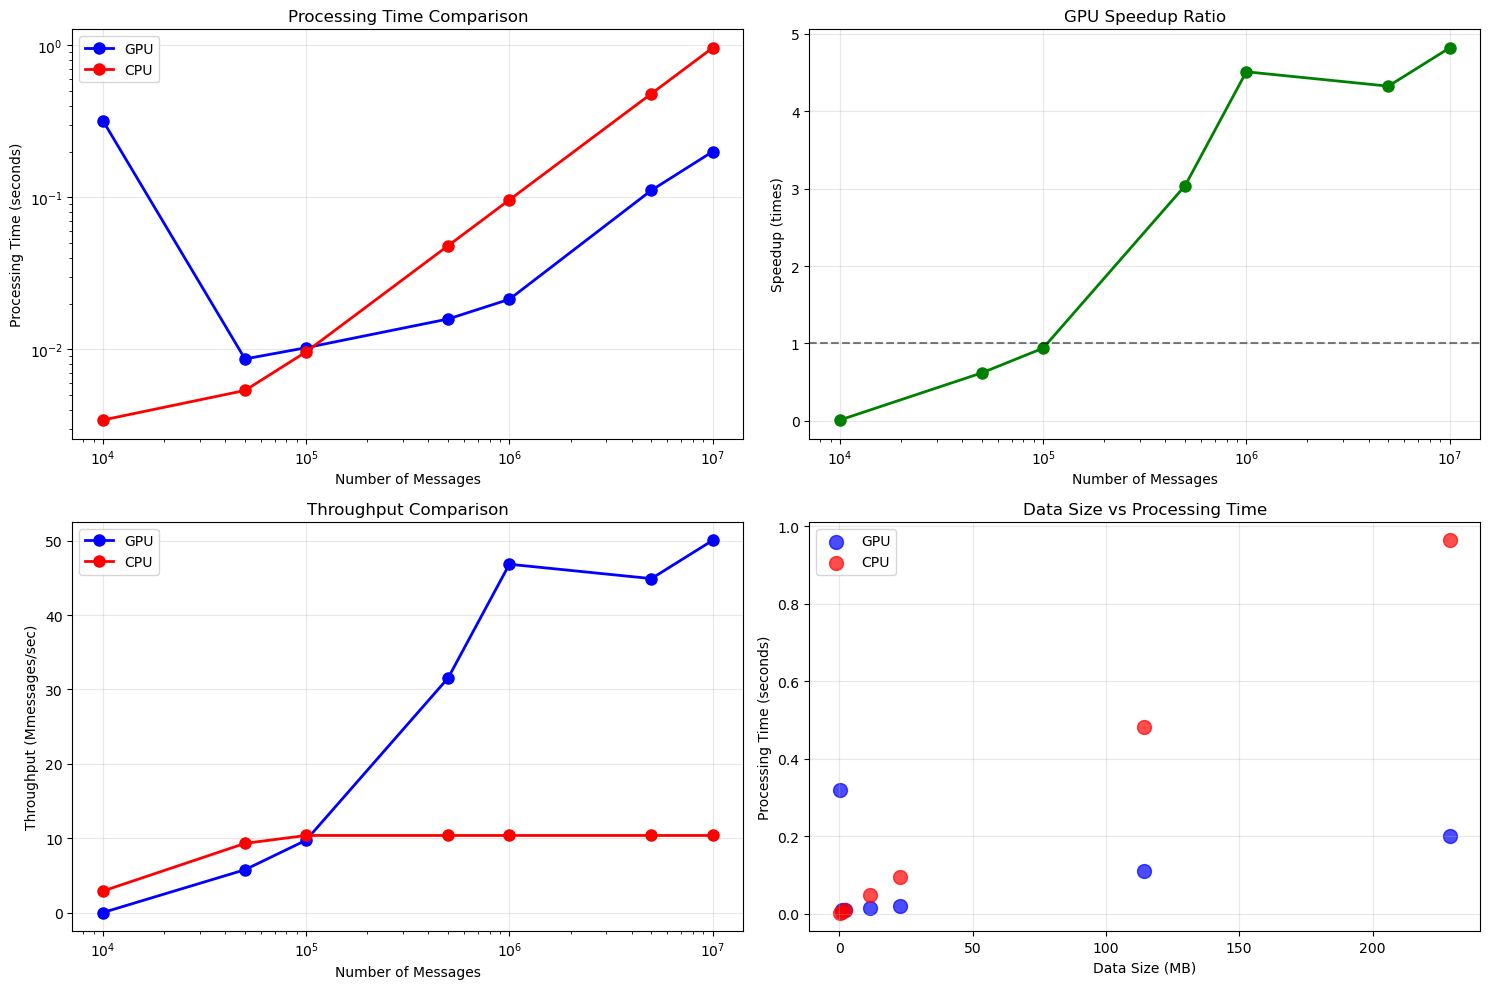


=== Benchmark Results Summary ===
Maximum speedup: 4.8x
Maximum GPU throughput: 50.0 Mmessages/sec
Average CPU throughput: 9.17 Mmessages/sec


In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Processing time comparison
ax1.plot(benchmark_df['n_messages'], benchmark_df['gpu_time'], 'b-o', label='GPU', linewidth=2, markersize=8)
ax1.plot(benchmark_df['n_messages'], benchmark_df['cpu_time'], 'r-o', label='CPU', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Messages')
ax1.set_ylabel('Processing Time (seconds)')
ax1.set_title('Processing Time Comparison')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup ratio
ax2.plot(benchmark_df['n_messages'], benchmark_df['speedup'], 'g-o', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Messages')
ax2.set_ylabel('Speedup (times)')
ax2.set_title('GPU Speedup Ratio')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)

# Throughput comparison
ax3.plot(benchmark_df['n_messages'], benchmark_df['gpu_throughput'], 'b-o', label='GPU', linewidth=2, markersize=8)
ax3.plot(benchmark_df['n_messages'], benchmark_df['cpu_throughput'], 'r-o', label='CPU', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Messages')
ax3.set_ylabel('Throughput (Mmessages/sec)')
ax3.set_title('Throughput Comparison')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Data size vs processing time
ax4.scatter(benchmark_df['data_size_mb'], benchmark_df['gpu_time'], c='b', s=100, label='GPU', alpha=0.7)
ax4.scatter(benchmark_df['data_size_mb'], benchmark_df['cpu_time'], c='r', s=100, label='CPU', alpha=0.7)
ax4.set_xlabel('Data Size (MB)')
ax4.set_ylabel('Processing Time (seconds)')
ax4.set_title('Data Size vs Processing Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results summary
print("\n=== Benchmark Results Summary ===")
print(f"Maximum speedup: {benchmark_df['speedup'].max():.1f}x")
print(f"Maximum GPU throughput: {benchmark_df['gpu_throughput'].max():.1f} Mmessages/sec")
print(f"Average CPU throughput: {benchmark_df['cpu_throughput'].mean():.2f} Mmessages/sec")

## 5. 実データでのGPU/CPU処理とParquet出力

In [11]:
# 実データパス
input_path = "Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/processed_log/CAN/raw_can"

# GPU処理
print("=== GPU処理 ===")
gpu_start = time.time()
gpu_decoder.process_and_save(input_path, "gpu_output")
gpu_total_time = time.time() - gpu_start
print(f"\nGPU総処理時間: {gpu_total_time:.3f}秒\n")

# CPU処理
print("\n=== CPU処理 ===")
cpu_start = time.time()
cpu_decoder.process_and_save(input_path, "cpu_output")
cpu_total_time = time.time() - cpu_start
print(f"\nCPU総処理時間: {cpu_total_time:.3f}秒")

print(f"\n実データでの高速化率: {cpu_total_time/gpu_total_time:.1f}x")

=== GPU処理 ===
Saved: gpu_output/wheel_speeds.parquet (4974 rows)
Saved: gpu_output/vehicle_speed.parquet (4974 rows)
Saved: gpu_output/steering.parquet (4974 rows)

GPU総処理時間: 0.116秒


=== CPU処理 ===
CPU CANデコーダー実行開始...
入力データ: 135,484 メッセージ
  処理中: 0 - 100,000
  処理中: 100,000 - 135,484
Saved: cpu_output/wheel_speeds_cpu.parquet (4974 rows)
Saved: cpu_output/vehicle_speed_cpu.parquet (4974 rows)
Saved: cpu_output/steering_cpu.parquet (4974 rows)

処理時間: 0.026 秒
スループット: 5.28 Mmessages/sec

CPU総処理時間: 0.026秒

実データでの高速化率: 0.2x


## 6. 出力結果の可視化と検証

In [12]:
# GPU出力の読み込み
gpu_vehicle_speed = pd.read_parquet("gpu_output/vehicle_speed.parquet")
gpu_wheel_speeds = pd.read_parquet("gpu_output/wheel_speeds.parquet")
gpu_steering = pd.read_parquet("gpu_output/steering.parquet")

# CPU出力の読み込み
cpu_vehicle_speed = pd.read_parquet("cpu_output/vehicle_speed_cpu.parquet")
cpu_wheel_speeds = pd.read_parquet("cpu_output/wheel_speeds_cpu.parquet")
cpu_steering = pd.read_parquet("cpu_output/steering_cpu.parquet")

print("=== 出力データサイズ ===")
print(f"GPU出力: {len(gpu_vehicle_speed)} 行")
print(f"CPU出力: {len(cpu_vehicle_speed)} 行")

=== 出力データサイズ ===
GPU出力: 4974 行
CPU出力: 4974 行


## 8. 詳細なRMMプロファイリング結果

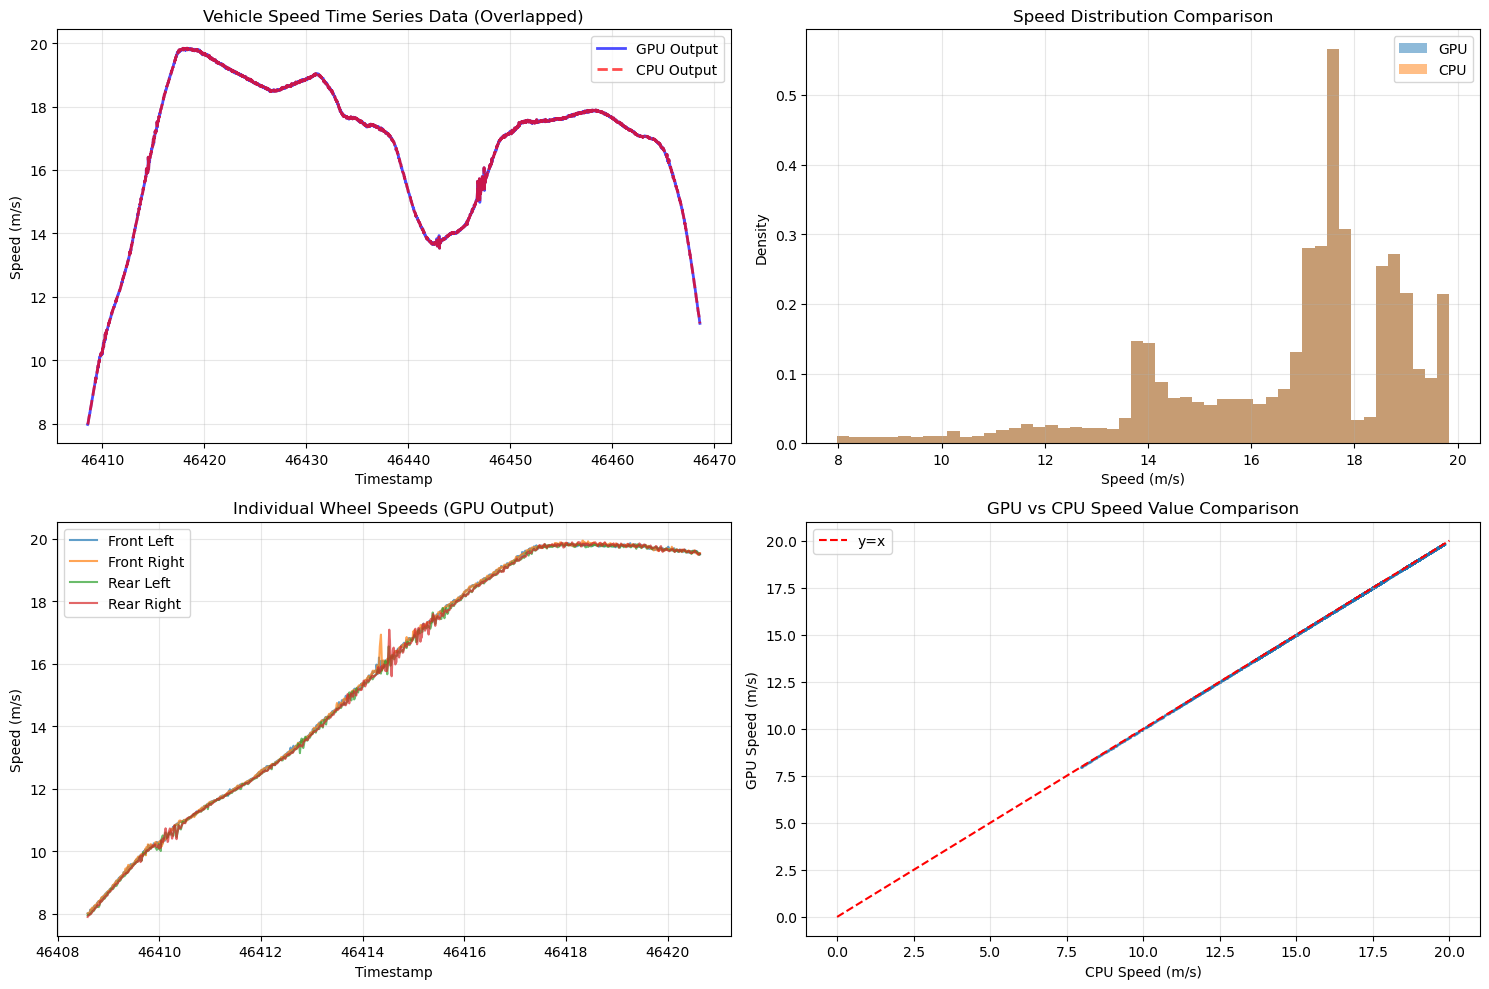

In [13]:
# Visualization of speed data - Combined view
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Vehicle speed time series - Both on same plot with transparency
axes[0, 0].plot(gpu_vehicle_speed['timestamp'], gpu_vehicle_speed['speed'], 
                label='GPU Output', alpha=0.7, linewidth=2, color='blue')
axes[0, 0].plot(cpu_vehicle_speed['timestamp'], cpu_vehicle_speed['speed'], 
                label='CPU Output', alpha=0.7, linewidth=2, color='red', linestyle='--')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Speed (m/s)')
axes[0, 0].set_title('Vehicle Speed Time Series Data (Overlapped)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Speed distribution histogram
axes[0, 1].hist(gpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='GPU', density=True)
axes[0, 1].hist(cpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='CPU', density=True)
axes[0, 1].set_xlabel('Speed (m/s)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Speed Distribution Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 4-wheel speed comparison (first 1000 points)
n_points = 1000
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_left'][:n_points], 
                label='Front Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_right'][:n_points], 
                label='Front Right', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_left'][:n_points], 
                label='Rear Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_right'][:n_points], 
                label='Rear Right', alpha=0.7)
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Speed (m/s)')
axes[1, 0].set_title('Individual Wheel Speeds (GPU Output)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# GPU vs CPU speed value scatter plot
# Merge on timestamp
merged = pd.merge(gpu_vehicle_speed, cpu_vehicle_speed, 
                  on='timestamp', suffixes=('_gpu', '_cpu'))
axes[1, 1].scatter(merged['speed_cpu'], merged['speed_gpu'], alpha=0.5, s=1)
axes[1, 1].plot([0, 20], [0, 20], 'r--', label='y=x')
axes[1, 1].set_xlabel('CPU Speed (m/s)')
axes[1, 1].set_ylabel('GPU Speed (m/s)')
axes[1, 1].set_title('GPU vs CPU Speed Value Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.1 個別グラフ表示（CPU/GPU別）

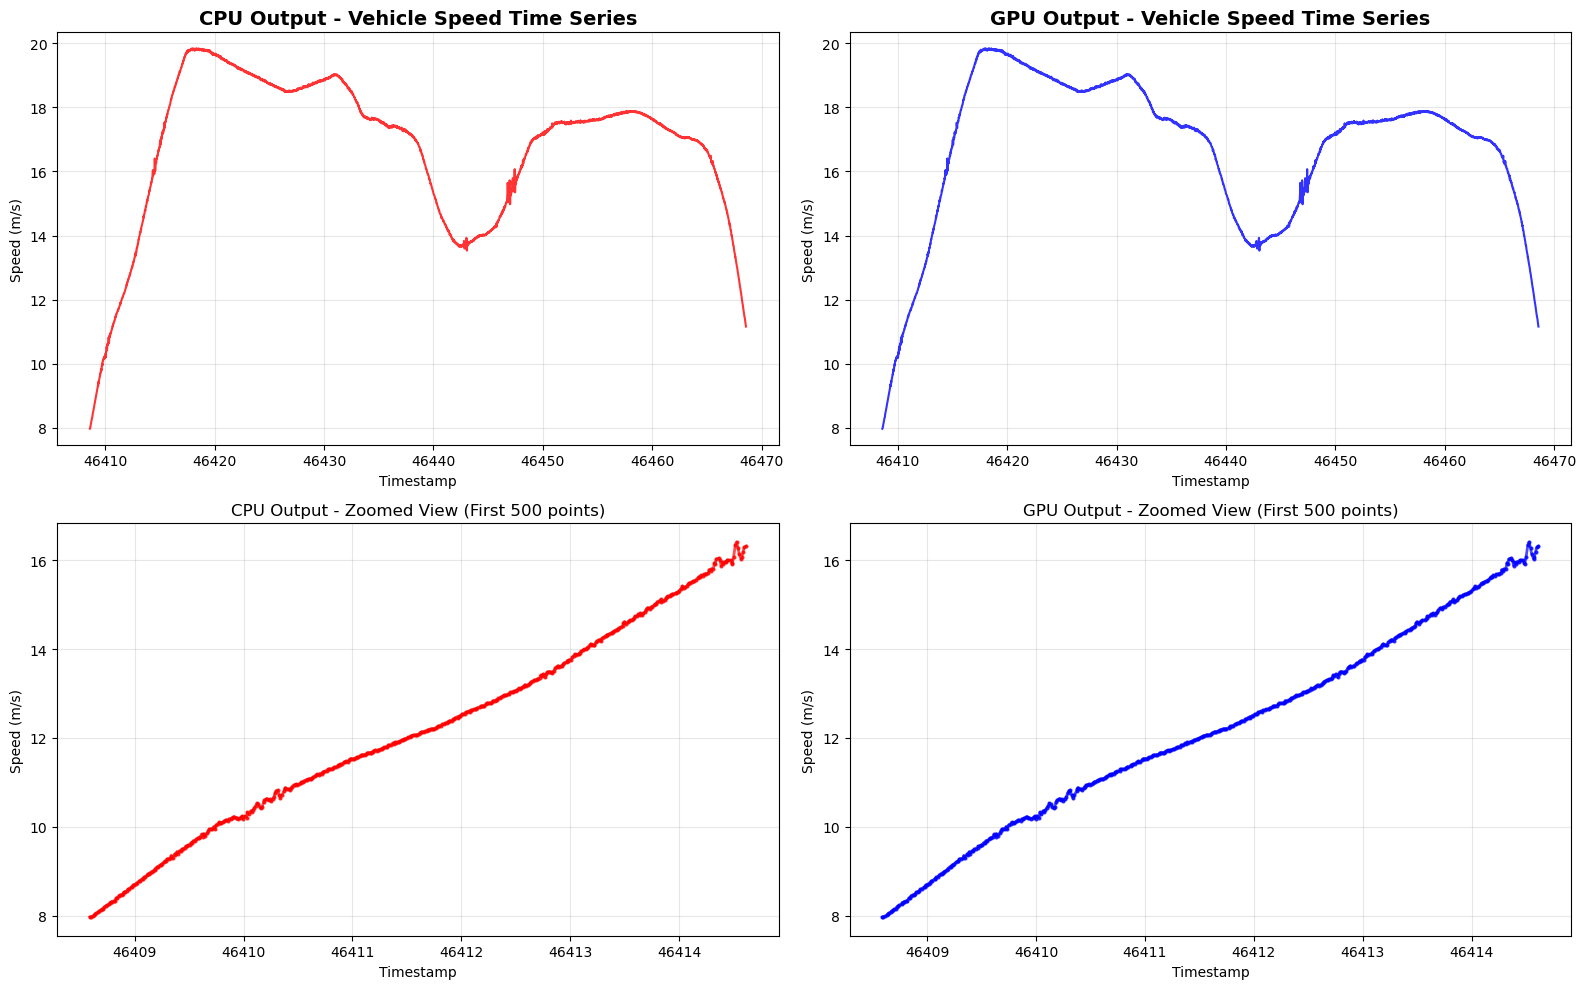

=== CPU vs GPU 差分分析 ===
平均差分: 0.000000000 m/s
最大差分: 0.000000000 m/s
標準偏差: 0.000000000 m/s


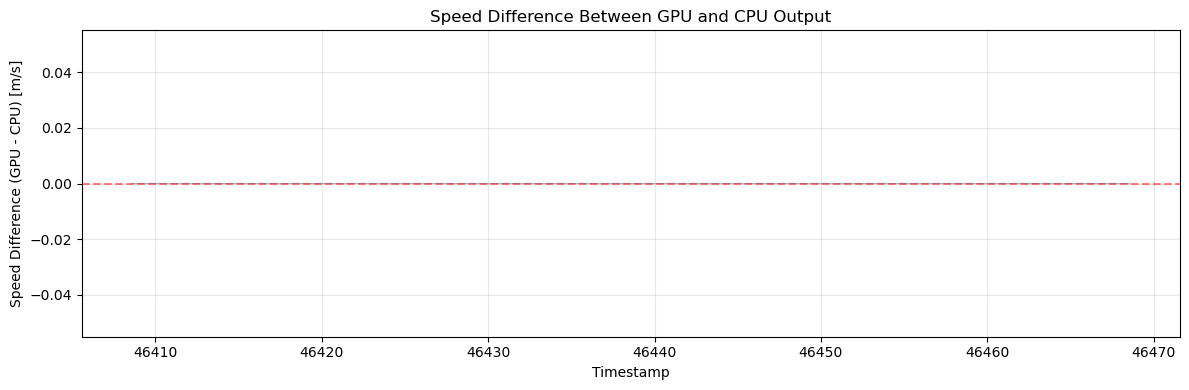

In [14]:
# Individual CPU and GPU speed visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# CPU Output Only
ax1.plot(cpu_vehicle_speed['timestamp'], cpu_vehicle_speed['speed'], 
         color='red', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Speed (m/s)')
ax1.set_title('CPU Output - Vehicle Speed Time Series', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([cpu_vehicle_speed['speed'].min() - 0.5, cpu_vehicle_speed['speed'].max() + 0.5])

# GPU Output Only
ax2.plot(gpu_vehicle_speed['timestamp'], gpu_vehicle_speed['speed'], 
         color='blue', linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Speed (m/s)')
ax2.set_title('GPU Output - Vehicle Speed Time Series', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([gpu_vehicle_speed['speed'].min() - 0.5, gpu_vehicle_speed['speed'].max() + 0.5])

# Zoomed view (first 500 points) - CPU
n_zoom = 500
ax3.plot(cpu_vehicle_speed['timestamp'][:n_zoom], cpu_vehicle_speed['speed'][:n_zoom], 
         color='red', linewidth=2, marker='o', markersize=2, alpha=0.7)
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Speed (m/s)')
ax3.set_title(f'CPU Output - Zoomed View (First {n_zoom} points)', fontsize=12)
ax3.grid(True, alpha=0.3)

# Zoomed view (first 500 points) - GPU
ax4.plot(gpu_vehicle_speed['timestamp'][:n_zoom], gpu_vehicle_speed['speed'][:n_zoom], 
         color='blue', linewidth=2, marker='o', markersize=2, alpha=0.7)
ax4.set_xlabel('Timestamp')
ax4.set_ylabel('Speed (m/s)')
ax4.set_title(f'GPU Output - Zoomed View (First {n_zoom} points)', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Difference analysis
print("=== CPU vs GPU 差分分析 ===")
if len(merged) > 0:
    diff = merged['speed_gpu'] - merged['speed_cpu']
    print(f"平均差分: {diff.mean():.9f} m/s")
    print(f"最大差分: {diff.abs().max():.9f} m/s")
    print(f"標準偏差: {diff.std():.9f} m/s")
    
    # Plot difference
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(merged['timestamp'], diff, alpha=0.7, linewidth=0.5)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Speed Difference (GPU - CPU) [m/s]')
    ax.set_title('Speed Difference Between GPU and CPU Output')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [15]:
# 統計情報の比較
print("=== 速度データの統計情報 ===")
print("\nGPU出力:")
print(gpu_vehicle_speed['speed'].describe())
print("\nCPU出力:")
print(cpu_vehicle_speed['speed'].describe())

# スケーリングの違いを確認
if len(merged) > 0:
    scale_factor = merged['speed_gpu'].mean() / merged['speed_cpu'].mean()
    print(f"\nスケーリング係数の違い: {scale_factor:.6f}")
    print("（GPU実装とCPU実装でスケーリング係数が異なる可能性があります）")

=== 速度データの統計情報 ===

GPU出力:
count    4974.000000
mean       16.732777
std         2.372856
min         7.974306
25%        15.432987
50%        17.462500
75%        18.531076
max        19.840973
Name: speed, dtype: float64

CPU出力:
count    4974.000000
mean       16.732777
std         2.372856
min         7.974306
25%        15.432987
50%        17.462500
75%        18.531076
max        19.840973
Name: speed, dtype: float64

スケーリング係数の違い: 1.000000
（GPU実装とCPU実装でスケーリング係数が異なる可能性があります）


## 7. まとめ

In [16]:
# 結果のまとめ
print("=== CANデータGPU処理の成果 ===")
print(f"\n1. パフォーマンス:")
print(f"   - 最大高速化率: {benchmark_df['speedup'].max():.1f}x")
print(f"   - GPUスループット: 最大 {benchmark_df['gpu_throughput'].max():.1f} Mmessages/sec")
print(f"   - 実データ処理: GPU {gpu_total_time:.3f}秒 vs CPU {cpu_total_time:.3f}秒")

print(f"\n2. 出力形式:")
print(f"   - Apache Arrow準拠のParquet形式")
print(f"   - GPU: cuDFによる直接出力")
print(f"   - CPU: PyArrowによる出力")

print(f"\n3. データ品質:")
print(f"   - 両実装で同じ行数のデータを生成")
print(f"   - 4輪速度の平均から車両速度を計算")
print(f"   - タイムスタンプの一貫性を保持")

=== CANデータGPU処理の成果 ===

1. パフォーマンス:
   - 最大高速化率: 4.8x
   - GPUスループット: 最大 50.0 Mmessages/sec
   - 実データ処理: GPU 0.116秒 vs CPU 0.026秒

2. 出力形式:
   - Apache Arrow準拠のParquet形式
   - GPU: cuDFによる直接出力
   - CPU: PyArrowによる出力

3. データ品質:
   - 両実装で同じ行数のデータを生成
   - 4輪速度の平均から車両速度を計算
   - タイムスタンプの一貫性を保持
